# Sprint 公開されている実装を動かす

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

以下は全てローカルで動かした

 # 問題1】学習と推定
READMEを参考に上記実装を動かしてください。

In [2]:
pwd

'/Users/morishuuya/Desktop/DIC/sprint/sprint17'

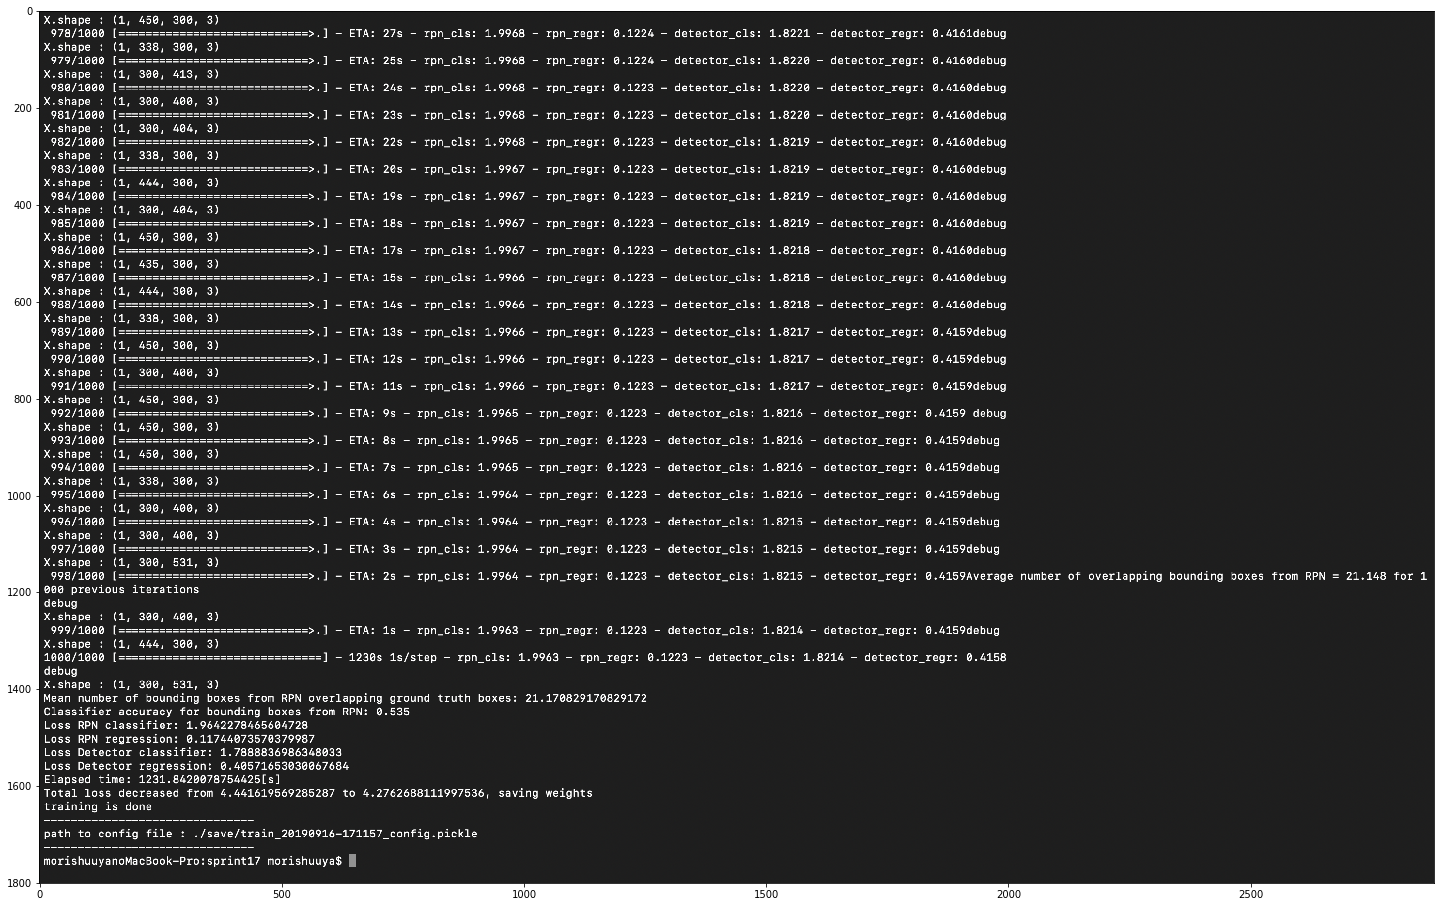

In [12]:
im = Image.open("/Users/morishuuya/Desktop/DIC/sprint/sprint17/sprint17_pic_1.png")
im_list = np.asarray(im)
plt.figure(figsize=(25, 25))
plt.imshow(im_list)
plt.show()

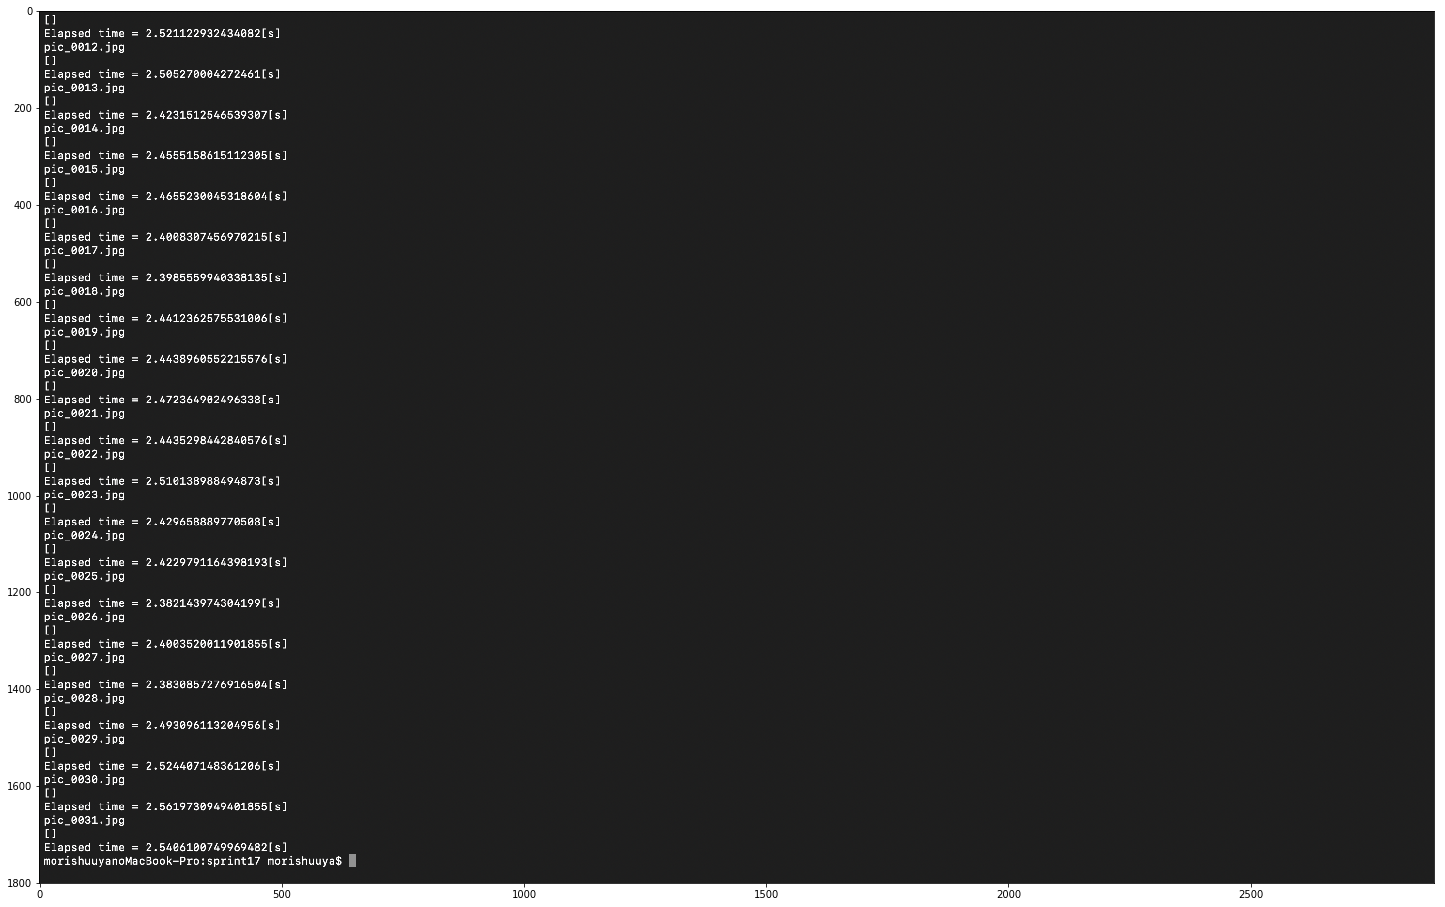

In [13]:
im = Image.open("/Users/morishuuya/Desktop/DIC/sprint/sprint17/sprint17_pic2.png")
im_list = np.asarray(im)
plt.figure(figsize=(25, 25))
plt.imshow(im_list)
plt.show()

学習できておらず、きちんと推定できていないが動かすことはできた。  
自分のkerasのバージョンが新しく以下の箇所を変更した  

1) image_dim ordering() → image_data_format()  
2) "tf" → "channels_last"

# 【問題2】論文と実装の対応
コードリーディングを行ってください。

## Roipooling
<pre>
    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'th':
            return None, self.num_rois, self.nb_channels, self.pool_size, self.pool_size
        else:
            return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels
   
   def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]
            
            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)

            num_pool_regions = self.pool_size

            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times

            if self.dim_ordering == 'th':
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = x + ix * row_length
                        x2 = x1 + row_length
                        y1 = y + jy * col_length
                        y2 = y1 + col_length

                        x1 = K.cast(x1, 'int32')
                        x2 = K.cast(x2, 'int32')
                        y1 = K.cast(y1, 'int32')
                        y2 = K.cast(y2, 'int32')

                        x2 = x1 + K.maximum(1,x2-x1)
                        y2 = y1 + K.maximum(1,y2-y1)
                        
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]

                        x_crop = img[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

            elif self.dim_ordering == 'tf':
                x = K.cast(x, 'int32')
                y = K.cast(y, 'int32')
                w = K.cast(w, 'int32')
                h = K.cast(h, 'int32')

                rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
                outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        if self.dim_ordering == 'th':
            final_output = K.permute_dimensions(final_output, (0, 1, 4, 2, 3))
        else:
            final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output

RoiPoolingConv.pyでRoiプーリングを行なっている  
conpute_output_shapeで出力する形を作る  
callでpoolingを行なっている  
最後にreshapeして出力サイズに合わせている

## RPN
<pre>
def main():
    args = parser.parse_args()
    time_stamp = "{0:%Y%m%d-%H%M%S}".format(datetime.now())
    save_name = os.path.join(args.save_dir, "train_{}".format(time_stamp))
    
    省略

   
    model_rpn, model_classifier, model_all = faster_rcnn.get_model(C, classes_count)
   
    faster_rcnnからrpnを受け取っている



<pre>
def rpn(base_layers,num_anchors):

    x = Convolution2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Convolution2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Convolution2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]
    
    faster_rcnnはresnetからrpnをうけとっている。
    元のrpnは上記のコードである
    
    畳み込み層を通して、分類と回帰問題のネットワークに送っている  
    num_anchorsはconfig.pyで指定している
    
    def get_model(C, classes_count):
    img_input = Input(shape=(None, None, 3)
    省略
    
     model_rpn.compile(optimizer=Adam(lr=1e-4), loss=[losses.rpn_loss_cls(num_anchors), losses.rpn_loss_regr(num_anchors)])
    model_classifier.compile(optimizer=Adam(lr=1e-4), loss=[losses.class_loss_cls, losses.class_loss_regr(len(classes_count)-1)], 
    metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
    model_all.compile(optimizer='sgd', loss='mae')
    
    rpnから出力された値を用いてkerasのモデルを作り、lossとしてlossesから分類と回帰のロスを計算している
    
    def main():
    args = parser.parse_args()
    time_stamp = "{0:%Y%m%d-%H%M%S}".format(datetime.now())
    save_name = os.path.join(args.save_dir, "train_{}".format(time_stamp))
    省略
    
     while True:
                try:
                    if len(rpn_accuracy_rpn_monitor) == args.n_iters and C.verbose:
                        mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                        rpn_accuracy_rpn_monitor = []
                        print('Average number of overlapping bounding boxes from RPN = {} for {} previous 
                        iterations'.format(mean_overlapping_bboxes, args.n_iters))
                        if mean_overlapping_bboxes == 0:
                            print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep
                            training.')
                    X, Y, img_data = next(data_gen_train)
                    
                    loss_rpn = model_rpn.train_on_batch(X, Y)
                    P_rpn = model_rpn.predict_on_batch(X)
                    R = roi_helpers.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, 
                    max_boxes=300)
                    
                    ここでrpnモデルの学習を行なっている
                    そして、推定を行いRoi poolingに送っている

## model
<pre>
 model_rpn, model_classifier, model_all = faster_rcnn.get_model(C, classes_count)
 
 model_allでrpnと分類を合わせたモデルを作成
 
  model_all.save_weights(C.model_path)
                        break
                        
  モデルを学習させ重みを保存した

# 【問題3】学習済みの重みによる推定
学習済みの重みを使い推定を行う方法がREADME.mdのQuick Startの項に記載されています。
まずはこの通りにして各自何かしらの画像や動画に対して検出を行ってください。
出力結果を課題の一部として提出してください。

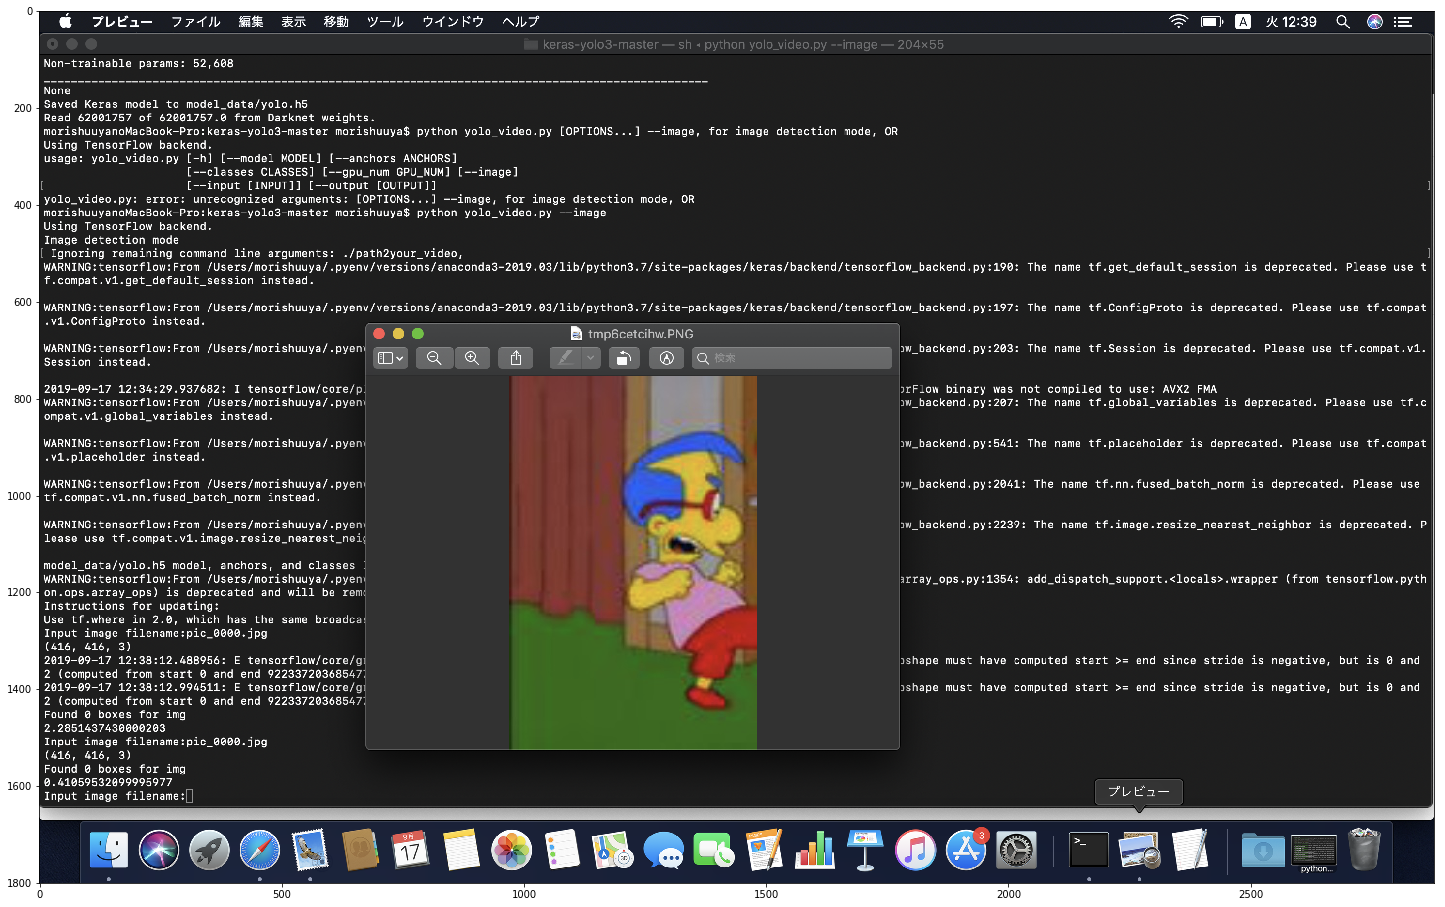

In [14]:
im = Image.open("/Users/morishuuya/Desktop/DIC/sprint/sprint17/sprint17_pic3.png")
im_list = np.asarray(im)
plt.figure(figsize=(25, 25))
plt.imshow(im_list)
plt.show()

ローカルで行なったため、エポック数などを落として行なった  
推定自体は行えたが、結果は良くなかった、  
found 0 boxesであった  

時間があるときにGPUを使ってやってみたい。  

# 【問題4】学習のためのファイルを作成
新しいデータ（シンプソンズデータセット）を学習します。README.mdのTrainingの項を読み、シンプソンズデータセットを学習するために必要なファイルを作成してください。
アノテーションファイルの形式が問題1の実装とは異なるため変換する必要があります。

別のノートブックで行なった処理を以下に示す　
<pre>

＃ライブラリインポート
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

＃エンコーダのインスタンス化、データのロード
le = LabelEncoder()
data = pd.read_csv("train.txt", names=["1", "2", "3", "4", "5", "6"])

＃ラベルのリストを取得し、エンコーダにfitし、transformした
trans_list = data.iloc[:, 5].unique()
trans_list = trans_list.tolist()
le.fit(trans_list)
new_data["6"] = le.transform(new_data["6"])

＃テキストファイルに変換
new_data.to_csv("train_revice.txt",  header=False, index=False)

# 【問題5】学習が行えることの確認
問題4で作成したファイルを使用して学習してください。実行環境で学習に時間がかかる場合は、学習が行えることを確認するのみで終えて構いません。

一箇所変更した  
utils.pyのsplit()をsplit(",",1)に変更した  

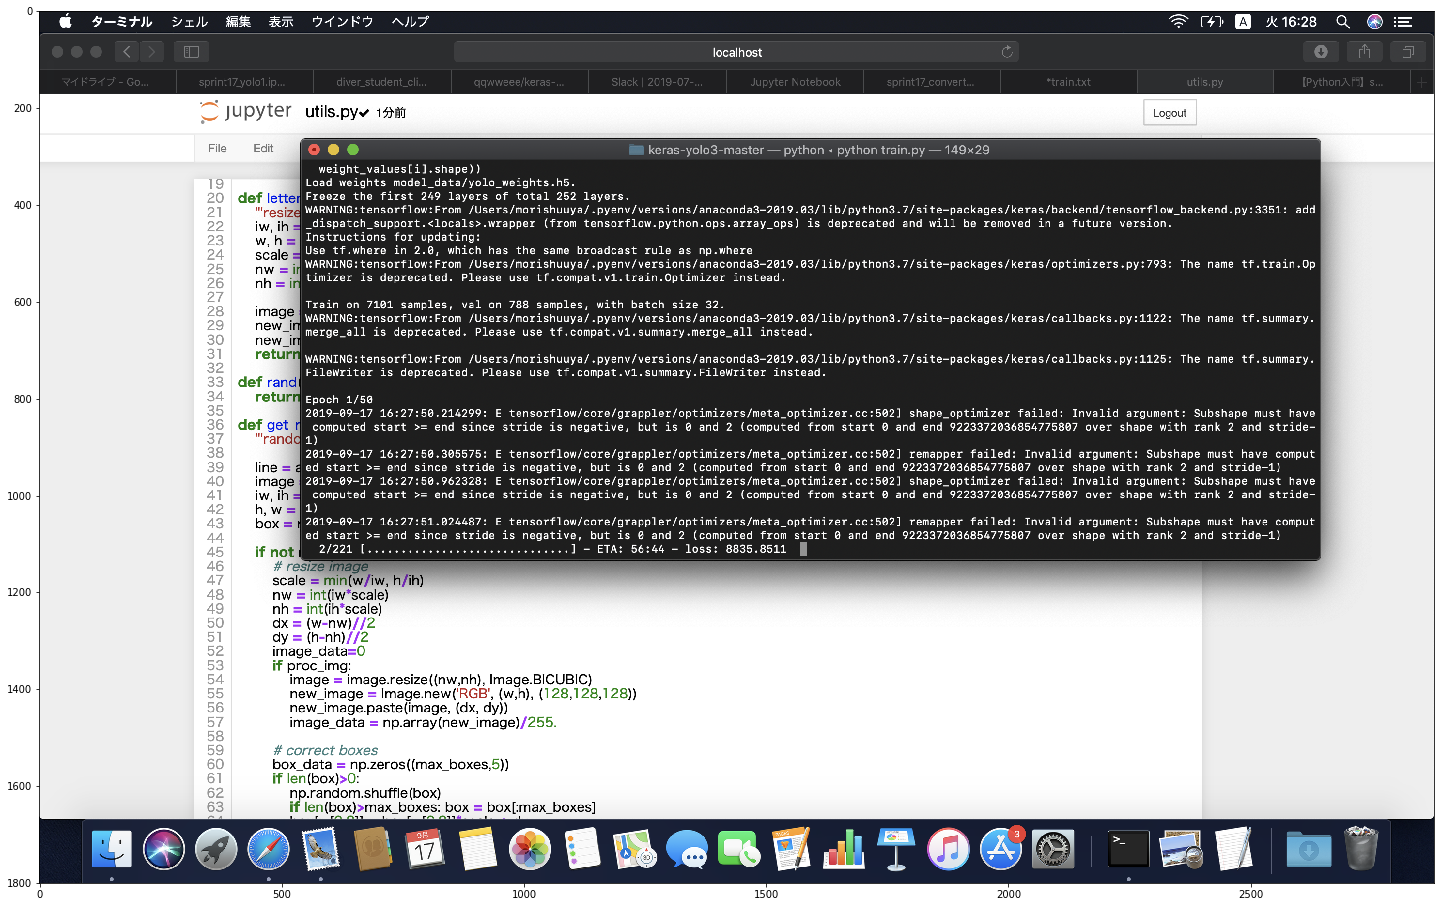

In [15]:
im = Image.open("/Users/morishuuya/Desktop/DIC/sprint/sprint17/sprint17_pic4.png")
im_list = np.asarray(im)
plt.figure(figsize=(25, 25))
plt.imshow(im_list)
plt.show()

学習を確認できた

ローカルで行なったため全体的に制約が多かった  
GPU環境を使えるようにする必要がある　　